In [1]:
!nvidia-smi

Mon Mar  6 19:32:20 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:02:00.0 Off |                  N/A |
| 43%   72C    P2   141W / 250W |   7620MiB / 11264MiB |     95%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:04:00.0 Off |                  N/A |
| 23%   

In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torchvision
from torchvision.models.detection.rpn import AnchorGenerator
import matplotlib.pyplot as plt
import torch.nn as nn
from PIL import Image, ImageDraw, ImageFont
import matplotlib.patches as patches
import random
import io
import utils
import preprocess as pre
import data_augmentation as aug
import DataLoader as dl
from torchvision import ops

In [2]:
from Model.AnchorGen import AnchorGenerator
from Model.Backbone_VGG16 import BackboneNetwork
from Model.rpn import RegionProposalNetwork
from Model.one_stage_detector import OneStageDetector

train_loader = dl.getCordTorchDatasetLoader("params_cord_initial.yaml", split='train')

In [4]:
config = utils.load_config_file("params_cord_initial.yaml")

In [6]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [8]:
device.index

1

In [7]:
model = OneStageDetector(config['IMG_WIDTH'], config['IMG_HEIGHT'], 512, 16, device="cuda:1")

/data/ik3g20/yann_ip/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/data/ik3g20/yann_ip/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
#model = nn.DataParallel(model.to(device))

In [9]:
model = model.to(device)

In [10]:
model.device

device(type='cuda', index=1)

In [11]:
model.load_state_dict(torch.load(config['SAVE_PATH'], map_location=device))
model.eval()

OneStageDetector(
  (backbone): BackboneNetwork(
    (bbNet): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inpla

In [12]:
!nvidia-smi

Mon Mar  6 19:32:29 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:02:00.0 Off |                  N/A |
| 43%   72C    P2   164W / 250W |   7620MiB / 11264MiB |     94%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:04:00.0 Off |                  N/A |
| 23%   

In [13]:
test_loader = dl.getCordTorchDatasetLoader("params_cord_initial.yaml", split='test')

Found cached dataset parquet (/home/ik3g20/.cache/huggingface/datasets/naver-clova-ix___parquet/naver-clova-ix--cord-v2-c97f979311033a44/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
/data/ik3g20/yann_ip/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data/ik3g20/yann_ip/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [14]:
first_batch = next(iter(test_loader))

In [15]:
test_imgs, test_targets = first_batch

In [16]:
test_imgs.shape

torch.Size([64, 3, 512, 512])

In [17]:
img1 = test_imgs[0]
gt_bboxes1 = test_targets['bboxes'][0]
gt_conf1 = test_targets['confidence scores'][0]

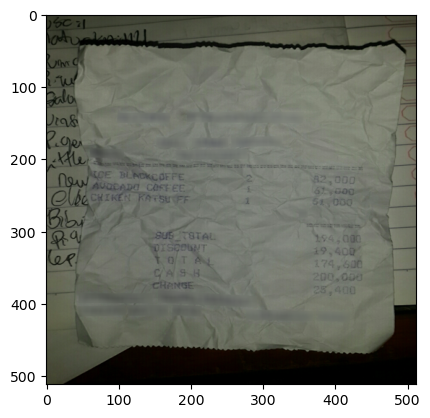

In [18]:
plt.imshow(img1.permute(1,2,0).numpy())

In [63]:
test_imgs = test_imgs.to(device)
preds = model.inference(test_imgs)

cuda:1


In [64]:
bboxes, confs = preds

In [65]:
bboxes1 = bboxes[0].cpu().data.numpy()
confs1 = confs[0].cpu().data.numpy()

In [66]:
bboxes1

array([[10.16676748, 20.147892  , 55.07281291, 54.68594933],
       [13.87576967, 14.57797575, 30.61244708, 26.74952269],
       [ 7.43852985, 15.43165421, 26.51729071, 27.72499204],
       ...,
       [25.29331064, 19.40418816, 27.32459331, 24.43177366],
       [17.05915952, 19.67593074, 20.88944459, 23.76317668],
       [ 3.56338525, -4.87720871, 33.27812696, 62.5736618 ]])

In [67]:
bboxes1 = np.where(bboxes1 > 0, bboxes1, 0)

In [68]:
bboxes1[...,[0,2]] = (bboxes1[...,[0,2]] / np.max(bboxes1[...,[0,2]])) * 512
bboxes1[...,[1,3]] = (bboxes1[...,[1,3]] / np.max(bboxes1[...,[1,3]])) * 512

In [69]:
#bboxes1 = bboxes1.astype('int64')

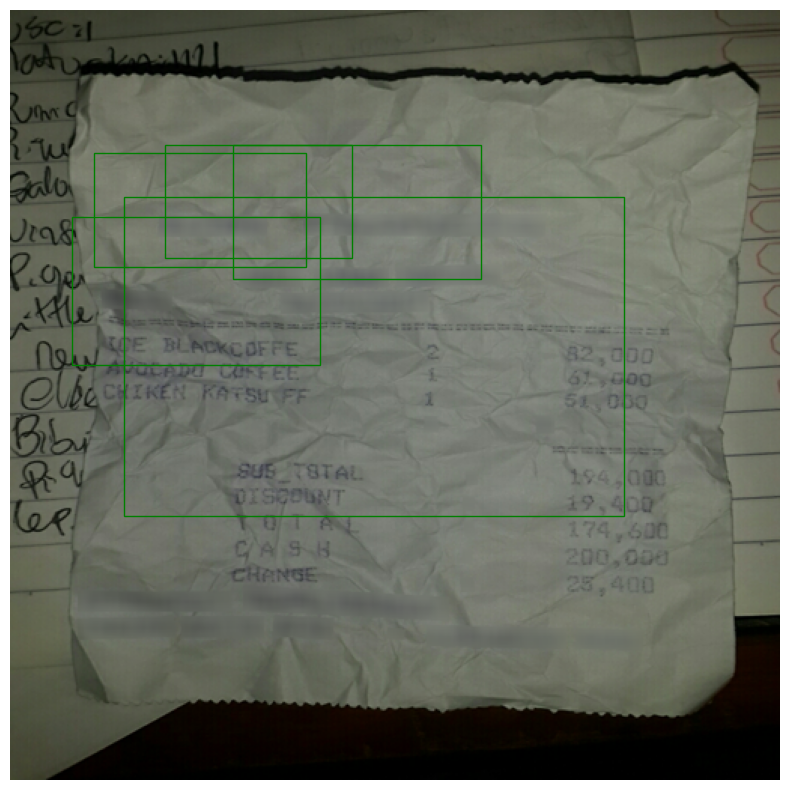

In [70]:
fig, ax = plt.subplots(figsize=(10,10))

ax.imshow(test_imgs[0].permute(1,2,0).cpu().numpy())

for idx, conf in enumerate(confs1):
    if conf > 0.8:
        x1, y1, x3, y3 = bboxes1[idx]
        
        rect = patches.Rectangle((x1, y1), (x3-x1), (y3-y1), linewidth=1, edgecolor='g', facecolor='none')
        ax.add_patch(rect)
plt.axis('off')
plt.show()

In [71]:
512 // 16

32

In [3]:
import multiprocessing as mp
from torch.distributed import init_process_group, destroy_process_group
from torch.utils.data.distributed import DistributedSampler
from torch.nn.parallel import DistributedDataParallel as DDP


In [5]:
def setupDDP(rank, worldsize):
    os.environ["MASTER_ADDR"] = "localhost"
    os.environ["MASTER_PORT"] = "28961"
    
    init_process_group(backend="nccl", rank=rank, worldsize=worldsize)

In [9]:
class OSDTrainer():
    def __init__(self, rank, config_name=None):
        assert config_path != None, "YAML Configuration File Name Under Configs Folder Is Needed"
        
        self.config = utils.load_config_file(config_name)
        self.rank = rank
        #self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        #Defining training dataset and model
        self.train_dataset = dl.getCordTorchDatasetLoader(config_name, split="train", include_sampler=True)
        self.model = OneStageDetector(self.config["IMG_WIDTH"], self.config["IMG_HEIGHT"], 512, 16,device=self.rank)
        self.model = self.model.to(self.rank)
        
        #Defining Optimizer
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.config["L_RATE"])
        
        #Defining the Model in terms of DistributedDataParallel
        self.model = DDP(self.model, device_ids=[self.rank])
        
        #Defining all losses list to monitor per epoch loss
        self.all_losses = []
    
    def getAllLosses(self):
        return self.all_losses
    
    def printOutput(self, eCount, eLoss):
        meanLoss = sum(self.all_losses) / len(self.all_losses)
        print("(GPU {0}, Epoch {1}) ==> Mean Loss :: {2}  | Epoch Loss :: {3}".format(self.device.index,eCount, meanLoss, eLoss))
    
    
    def single_epoch_run(self, epoch_count, images, bboxes, conf_scores):
        self.optimizer.zero_grad()
        
        model_loss = self.model(images, bboxes, conf_scores)
        
        model_loss.backward()
        
        self.optimizer.step()
        
        self.all_losses.append(model_loss)
        
        self.printOutput(epoch_count, model_loss)
        
        return model_loss
    
    def trainModel(self):
        save_path = "./Saved_Models/OSD_E_{0}_B_{1}_{2}x{3}_Checkpoint.pt".format(
                        self.config['EPOCHS'],self.config['BATCH'], self.config['IMG_WIDTH'], self.config['IMG_HEIGHT'])
        for epoch in range(self.config['EPOCHS']):
            prev_min_loss = 1e6
            for imgs, targets in self.train_dataset:
                imgs = imgs.to(self.rank)
                bboxes = target['bboxes'].to(self.rank)
                conf_scores = target['confidence scores'].to(self.rank)
                
                eLoss = self.single_epoch_run(epoch, imgs, bboxes, conf_scores)
                
                if (self.rank == 0) and (eLoss <= prev_min_loss):
                    model_dict = self.model.module.state_dict()
                    torch.save(model_dict, save_path)
                    prev_min_loss = eLoss
            
                

In [10]:
def runDDPTraining(rank, worldsize, config_name):
    setupDDP(rank, worldsize)
    modelTrainer = OSDTrainer(rank, config_name)
    modelTrainer.trainModel()
    destroy_process_group()

In [11]:
if __name__ == "__main__":
    config_name = "params_cord_initial.yaml"
    worldsize = torch.cuda.device_count()
    mp.spawn(runDDPTraining, args=(worldsize, config_name), nprocs=worldsize)
    

SyntaxError: unexpected EOF while parsing (1054539742.py, line 1)